# Building a Model to Predict Housing Prices



# Index

- [Abstract](#Abstract)
- [1. Introduction](#1.-Introduction)
- [2. The Data](#2.-The-Data)
    - [2.1 Import the Data](#2.1-Import-the-Data)
    - [2.2 Data Exploration](#2.2-Data-Exploration)
    - [2.3 Data Preparation](#2.3-Data-Preparation)
    - [2.4 Correlation](#2.4-Correlation)
- [3. Project Description](#3.-Project-Description)
    - [3.1 Linear Regression](#3.1-Linear-Regression)
    - [3.2 Analysis](#3.2-Analysis)
    - [3.3 Results](#3.3-Results)
    - [3.4 Verify Your Model Against Test Data](#3.4-Verify-Your-Model-Against-Test-Data)
- [Conclusion](#Conclusion)
- [References](#References)

[Back to top](#Index)


##  Abstract

This project is about using data collected in the past to predict the price of a new house on the market. The database available today tabulates 89 columns for each houses sold and there is 1000 sales in the record. The columns range from price sales to overall quality of the house to number of bathrooms, etc. The format of each columns ranges from numeric to date to text. The first task was to transform text to numeric. Then to treat the NA values. At that point, the data is clean and composed of numeric only. The correlation factor with regards to SalePrice has been computed for each variable and sorted from greater to lower value to get a sense of which variable is the most correlated with the SalePrice. Then a multiple linear regression model has been trained with the selected multiple variables. The R^2 value has been computed. The same process has been repeated with a test data set and the R^2 has been computed. Finally and analysis of convergence with regards to the number of variable used to train the model has been conducted

[Back to top](#Index)


## 1. Introduction

The goal of the project is to be able to predict a priori the price of any home based on its characteristics such as year built, square footage, number of room, ... 
The first step is to understand the data and answer the following questions: What is the meaning of each columns, is the data accurate, is there any missing data how to convert test data into numerics? Then to train the model it will be needed to find which columns are the most correlated with SalePrice.
Then the training data will be used to train the linear regression model and this will be compared with the test data. Finally, a sensitivity analysis will be conducted to improve the model.


[Back to top](#Index)

## 2. The Data


[Back to top](#Index)

### 2.1 Import the Data



In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
#data is the training data that will be used to train the model
data=pd.read_csv('houseSmallData.csv')
#test is the test data that will be used to validate the linear regression model
test=pd.read_csv('jtest.csv')

[Back to top](#Index)

### 2.2 Data Exploration


The .info() function will return the number or rows and columns and it's respective names. It will as well return the format of each columns and the number of non null values. This is an excellent start to get familiar with the raw data

In [317]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     100 non-null    int64  
 1   Id             100 non-null    int64  
 2   MSSubClass     100 non-null    int64  
 3   MSZoning       100 non-null    object 
 4   LotFrontage    86 non-null     float64
 5   LotArea        100 non-null    int64  
 6   Street         100 non-null    object 
 7   Alley          6 non-null      object 
 8   LotShape       100 non-null    object 
 9   LandContour    100 non-null    object 
 10  Utilities      100 non-null    object 
 11  LotConfig      100 non-null    object 
 12  LandSlope      100 non-null    object 
 13  Neighborhood   100 non-null    object 
 14  Condition1     100 non-null    object 
 15  Condition2     100 non-null    object 
 16  BldgType       100 non-null    object 
 17  HouseStyle     100 non-null    object 
 18  OverallQual

We can see that there is several columns with text only that will need to be cleaned as well as several columns with numerous null. 

The zoning will probably play a big role in the price of the house as well as the location of the house. There is more or less expensive neighborhood and a house close to a noisy interstate or railroad usually will be less expensive. A pivot table aggregating on the mean of the sale price will help to see that effect.

In [318]:
zoning=pd.pivot_table(data,index='MSZoning',values='SalePrice',aggfunc=np.mean).sort_values(by='SalePrice',ascending=False)
zoning

,SalePrice
MSZoning,
FV,195566.666667
RL,188325.205128
RM,115443.750000
C (all),86300.000000


In [319]:
Neighborhood=pd.pivot_table(data,index='Neighborhood',values='SalePrice',aggfunc=np.mean).sort_values(by='SalePrice',ascending=False)
Neighborhood

,SalePrice
Neighborhood,
StoneBr,438780.000000
NridgHt,295388.888889
Veenker,283250.000000
NoRidge,255000.000000
Somerst,227740.000000
ClearCr,225000.000000
NWAmes,200000.000000
CollgCr,193278.571429
Gilbert,177900.000000


We can see that Neighborhood such as StoneBridge and Residential low-density zoning will make the price of the house higher

Let's now plot box plots of several key variables to understand more in details the spread of the data: ['MSZoning','Neighborhood','Condition1','BldgType','OverallQual','BsmtQual','HouseStyle','CentralAir','Electrical','HeatingQC','Heating','Foundation']

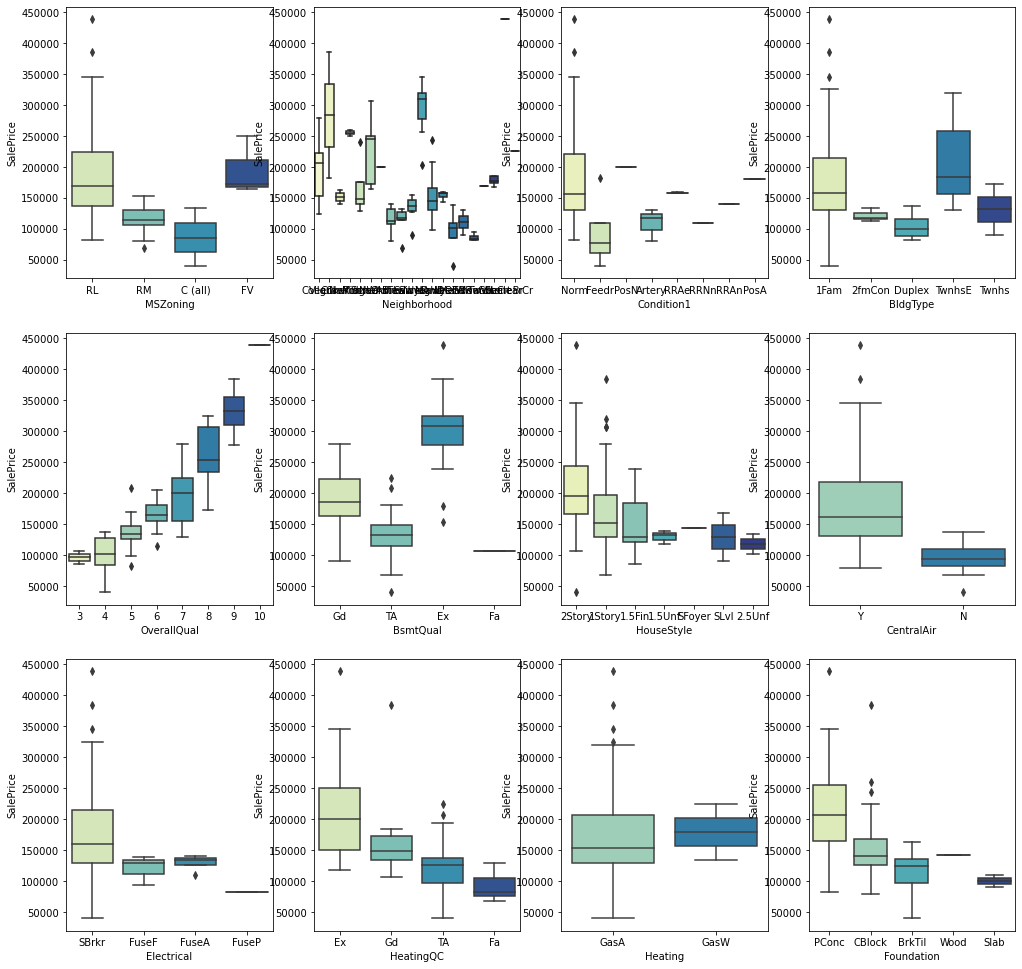

In [320]:
k=0
List=['MSZoning','Neighborhood','Condition1','BldgType','OverallQual','BsmtQual','HouseStyle','CentralAir','Electrical','HeatingQC','Heating','Foundation']
fig, ax = plt.subplots(3, 4, figsize= (17,17))
for i in range (0,3):
    for j in range(0,4):
        sns.boxplot(x=List[k], y='SalePrice', data=data, palette='YlGnBu', ax=ax[i, j])
        k=k+1

Many conclusions can be drawn at that point from the box plots. For instance, a house with no central air will never have a high price. Same conclusion for a 2 family condominium. 
We can see that the Overall quality is strongly correlated to the SalePrice.


Then to understand further the data, the joinplot is a great tool to see the distribution of each variables and the influence of a variable on another one.

(0.0, 500000.0)

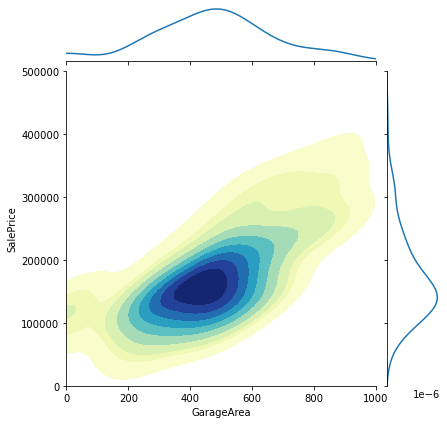

In [321]:
plot=sns.jointplot(x='GarageArea',y='SalePrice',data=data, kind='kde',shade=True,cmap='YlGnBu')
plot.ax_marg_x.set_xlim(0, 1000)
plot.ax_marg_y.set_ylim(0, 500000)

It can be seen that the bigger the garage is the higher the price is. 

(0.0, 500000.0)

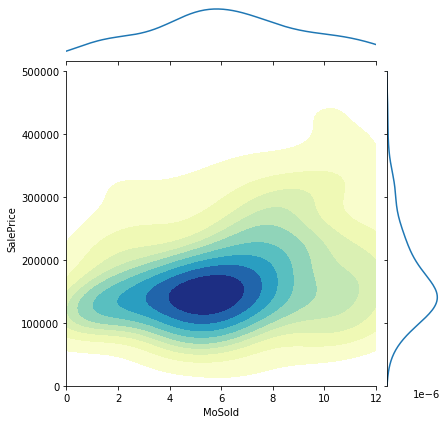

In [322]:
plot=sns.jointplot(x='MoSold',y='SalePrice',data=data, kind='kde',shade=True,cmap='YlGnBu')
plot.ax_marg_x.set_xlim(0, 12)
plot.ax_marg_y.set_ylim(0, 500000)

It can be seen that from January to March, the market is very quiet, not a lot of sales and little SalePrice. The highest number of sales are around June. The biggest SalePrice will happen around November

Let's look at the influence of the living square feet on the SalePrice. Let's plot these two variables on a scatter plot. Let's color the point per garage area and size the points per overall quality to see the influence of these 3 variables on one single plot. 

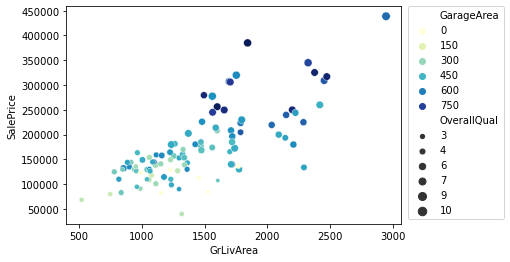

In [323]:
sns.scatterplot(data=data, x="GrLivArea", y="SalePrice", hue="GarageArea", size="OverallQual",palette='YlGnBu')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

This plot shows that the sale price is proportional to the ground living area. When the price is overestimated, it is because either the overall quality is high or there is additional space coming from the garage.

[Back to top](#Index)

### 2.3 Data Preparation

Let's transform the test data into numeric to be able to include in the linear regression as many relevant variable as possible.

Let's transform the text below into numbers ranging from 0 to 5 with 0 representing NA.

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor


       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
       
Let's do hot encoding to transform categorical data into numerical data for the following columns:
MSZoning, BldgType, Electrical, Neighborhood, CentralAir, HouseStyle, Condition1

Let's fill the remaining NA with the avg value of each columns.

A function as been created for repeatability purposes. I use the same function to treat the training data and the test data. Additionally, if someone else wants to use my code it will be easier to share.

In [324]:
def clean_data(data):
    data.drop(['Alley','PoolQC'],axis=1)

    data=data.replace({'Ex': 5, 'Gd': 4,'TA': 3, 'Fa': 2, 'Po' : 1, 'NA' : 0})
    data=data.replace({'GLQ': 6,'ALQ': 5, 'BLQ': 4,'Rec': 3, 'LwQ': 2, 'Unf' : 1, 'NA' : 0})
    data=data.replace({'N': 0, 'Y': 1})

    dummy_zoning = pd.get_dummies(data['MSZoning'])
    data = data.join(dummy_zoning)

    dummy_building = pd.get_dummies(data['BldgType'])
    data = data.join(dummy_building)

    dummy_Electrical = pd.get_dummies(data['Electrical'])
    data = data.join(dummy_Electrical)

    dummy_Neighborhood = pd.get_dummies(data['Neighborhood'])
    data = data.join(dummy_Neighborhood)

    dummy_Air = pd.get_dummies(data['CentralAir'])
    data = data.join(dummy_Air)

    dummy_House = pd.get_dummies(data['HouseStyle'])
    data = data.join(dummy_House)

    dummy_condition1 = pd.get_dummies(data['Condition1'])
    data = data.join(dummy_condition1)
    
    data=data.select_dtypes(include=[np.number]).interpolate().dropna(axis=1)

    return data

In [325]:
data=clean_data(data)

The describe function if very useful to get a glance at the statistics of each columns.

In [326]:
#select numeric columns
# calculate correlation factor

print(data.shape)
data.describe()

(100, 100)


,Unnamed: 0,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SFoyer,SLvl,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNn
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,...,100.00,100.000000,100.000000,100.000000,100.000000,100.00,100.00,100.000000,100.00,100.00
mean,49.500000,50.500000,52.000000,71.595000,10115.870000,5.980000,5.50000,1971.410000,1983.920000,121.640000,...,0.01,0.030000,0.030000,0.040000,0.870000,0.01,0.01,0.020000,0.01,0.01
std,29.011492,29.011492,42.545282,20.518985,5130.541763,1.530696,0.97959,29.373284,20.967353,213.553982,...,0.10,0.171447,0.171447,0.196946,0.337998,0.10,0.10,0.140705,0.10,0.10
min,0.000000,1.000000,20.000000,21.000000,1596.000000,3.000000,2.00000,1910.000000,1950.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00
25%,24.750000,25.750000,20.000000,60.000000,7643.250000,5.000000,5.00000,1954.750000,1964.750000,0.000000,...,0.00,0.000000,0.000000,0.000000,1.000000,0.00,0.00,0.000000,0.00,0.00
50%,49.500000,50.500000,45.000000,70.000000,9595.500000,6.000000,5.00000,1970.000000,1994.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,1.000000,0.00,0.00,0.000000,0.00,0.00
75%,74.250000,75.250000,60.000000,84.250000,11243.250000,7.000000,6.00000,2000.250000,2003.250000,188.500000,...,0.00,0.000000,0.000000,0.000000,1.000000,0.00,0.00,0.000000,0.00,0.00
max,99.000000,100.000000,190.000000,122.000000,50271.000000,10.000000,8.00000,2009.000000,2009.000000,1115.000000,...,1.00,1.000000,1.000000,1.000000,1.000000,1.00,1.00,1.000000,1.00,1.00


[Back to top](#Index)

### 2.4 Correlation

At that point, the data table is now cleaned and composed from only numeric. Let's apply to this table a correlation function and let's let's filter and sort it's values so that we can see what are the most correlated values with SalePrice. Not to forget to include negative values too!

In [327]:
corr=data.corr()
cols=corr['SalePrice'].sort_values(ascending=False).index
cols[0:20]

Index(['SalePrice', 'OverallQual', 'BsmtQual', 'ExterQual', 'GrLivArea',
       'GarageArea', 'KitchenQual', 'GarageCars', 'YearBuilt', 'TotalBsmtSF',
       'GarageYrBlt', 'FullBath', 'MasVnrArea', 'TotRmsAbvGrd', '1stFlrSF',
       'YearRemodAdd', 'HeatingQC', 'NridgHt', 'LotArea', 'Fireplaces'],
      dtype='object')

Filter only the variables that are the most correlated (positively and negatively) to the SalePrice variable

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SalePrice'>

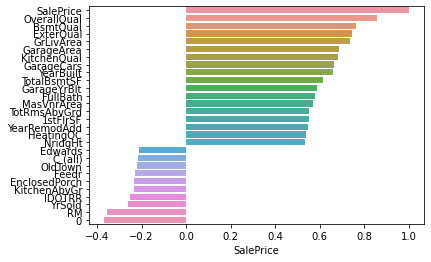

In [328]:
X1=corr[(corr['SalePrice'].values>0.5) | (corr['SalePrice'].values<-0.2)]['SalePrice'].sort_values(ascending=False)
Y1=corr[(corr['SalePrice'].values>0.5) | (corr['SalePrice'].values<-0.2)]['SalePrice'].sort_values(ascending=False).index
sns.barplot(X1,Y1)

The variable the most correlated with SalePRice are plotted above and they are all positive. 

Let's plot histograms of all these variable to see if the follow any canonical statistical repartitions.

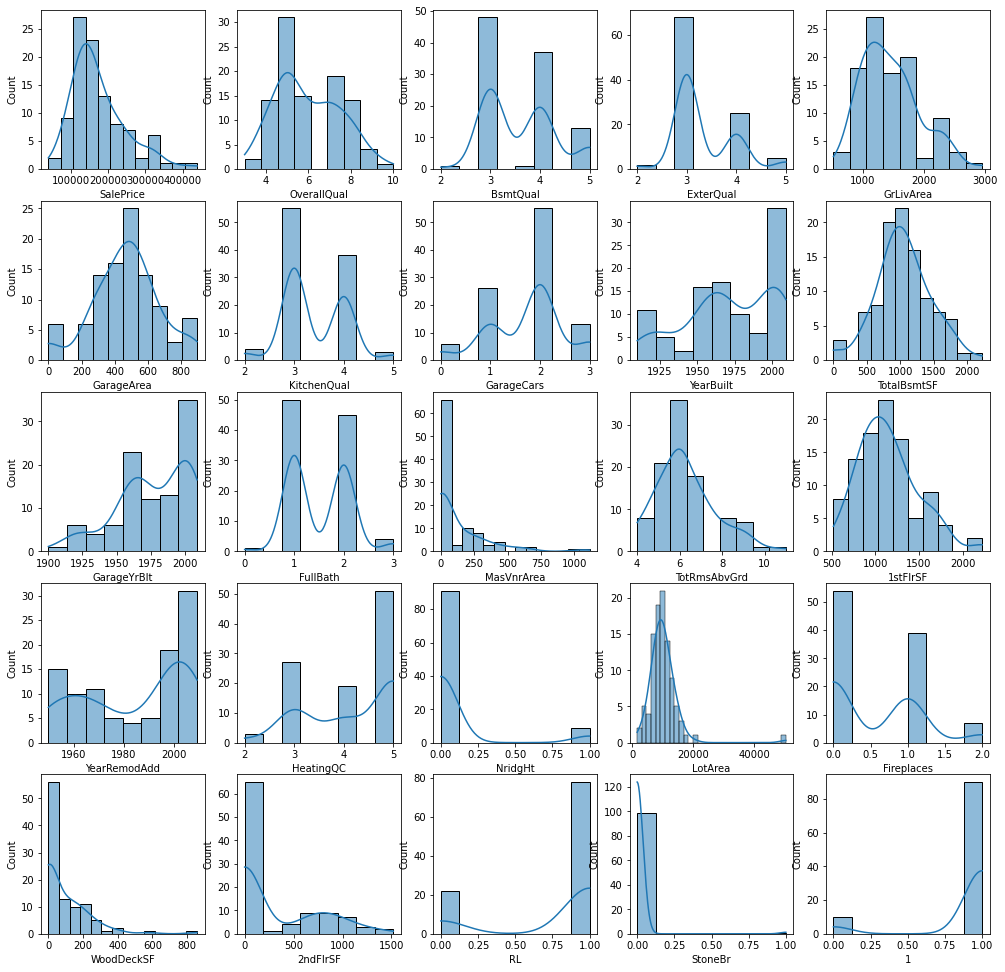

In [329]:
k=0
fig, ax = plt.subplots(5, 5, figsize= (17,17))
for i in range (0,5):
    for j in range(0,5):
        sns.histplot(data[cols[k]], kde=True, ax=ax[i, j])
        k=k+1

We can see that sale price is skewed. Total Basement surface and garage area follow a normal distribution and Wood deck surface follows and exponential distribution. 

Let's look at the correlation of each variables containing Qual to see if they are strongly correlated to Overall qual.

<AxesSubplot:>

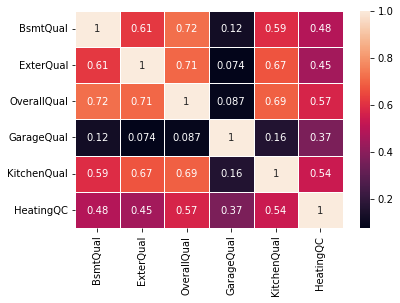

In [330]:
List_Qual=['BsmtQual','ExterQual','OverallQual','GarageQual','KitchenQual','HeatingQC']
Cor_Qual=corr[List_Qual]
sns.heatmap(Cor_Qual.loc[List_Qual], annot=True, linewidths=.5)

They are all strongly correlated to Overall qual except for garage qual but not enough to be dropped.

I wanted to check if the OverallQual variable was much correlated with the sub quality categories. What can be seen is that the garage quality is not correlated with the Overall quality so it is good to keep these two variable to train our regression model.


[Back to top](#Index)

## 3. Project Description

To try to improve the model made by Pr. Williams, more than 3 of the most correlated variables with SalePRice will be considered. A for loop ranging from 1 to 40 will be introduce to iterate on the number of variable included to train the linear regression model. Then the R2 will be plot to track the convergence of the model.


[Back to top](#Index)

### 3.1 Linear Regression

In this part, the linear regression model is selected to model the SalePrice relationship with several other variables. Linear regression model is also called lest square model since the algorithm will try to fit a line on top of a data set, compute the norm2 for each point, and try du minimize this value. To do so, the algorithm will have two degrees of freedom, the bias and the weight of the equation:

$$ y = \beta_{0}+\beta_{1}x_{1} $$


Since we are considering several independent variables, a multi-linear regression model will be used. It works similarly that a classic 2DOF model but with mode DOF. Below the equation of such a model with n+1 DOF


$$ y = \beta_{0}+\beta_{1}x_{1}+\beta_{2}x_{2}+...+\beta_{n}x_{n} $$


[Back to top](#Index)

### 3.2 Analysis 


Text(0.5, 0, 'Independant variables')

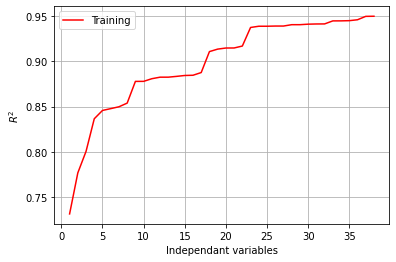

In [331]:
#Initialization of the R2 table that will collect all the R2 values  
Rtraining=[]
#for loop iterating on the number of colomns included in the model
for i in range(2,40,1):
    cols=corr['SalePrice'].sort_values(ascending=False)[0:i].index
    #pick out x cols and Y =SalePrice
    X=data[cols]
    Y=data['SalePrice']
    X=X.drop(['SalePrice'],axis=1)
    #creating the linear model
    lr = linear_model.LinearRegression()
    #training the linear model
    model=lr.fit(X,Y)
    #computing the prediction
    predictions=model.predict(X)
    #Computing the R2 coefficient
    Rtraining.append(model.score(X,Y))
    
#ploting the results
ListX=np.arange(1,len(Rtraining)+1,1)
plt.plot(ListX, Rtraining, label='Training', color='r')
plt.grid(True)
plt.legend()
plt.ylabel(r'$R^2$')
plt.xlabel('Independant variables')

After including more than the 20 most correlated variables to SalePRice it can be seen that the R2 is plateauing below 0.95.

[Back to top](#Index)

### 3.3 Results

In this part, let's use 20 variables to train the model as a result of the previous convergence analysis and let's plot the data versus the predicted data and histograms of the prediction - the data from the training data base.

R^2 is: 0.9135739698065676


Text(0.5, 0, 'Predictions')

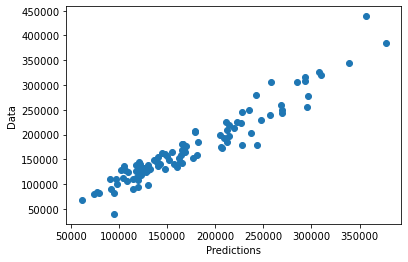

In [332]:
NbValues=20

X=data[cols[0:NbValues]]
Y=data['SalePrice']
X=X.drop(['SalePrice'],axis=1)
X.describe()
#build linear regression model
lr = linear_model.LinearRegression()
model=lr.fit(X,Y)
predictions=model.predict(X)
print(f"R^2 is: {model.score(X,Y)}")
plt.scatter(predictions, Y)
plt.ylabel('Data')
plt.xlabel('Predictions')

Text(0.5, 1.0, 'Predictions - Data')

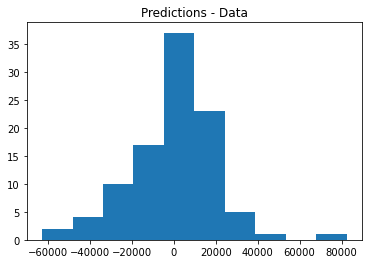

In [333]:
plt.hist(Y-predictions)
plt.title('Predictions - Data')

[Back to top](#Index)

### 3.4 Verify Your Model Against Test Data
Now let's repeat the same steps followed with the training data to the test data and compare the results.

In [334]:
test=clean_data(test)

In [335]:
X=test[cols[0:NbValues]]
Y=X['SalePrice']
X=X.drop(['SalePrice'],axis=1)

predictions=model.predict(X)
print(f"R^2 is: {model.score(X,Y)}")

R^2 is: 0.7803592478282342


Text(0.5, 1.0, 'Predictions - Data')

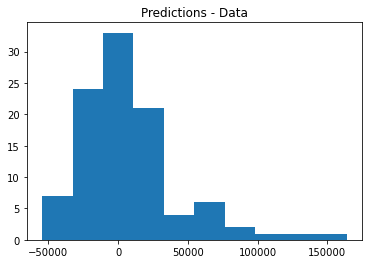

In [336]:
plt.hist(Y-predictions)
plt.title('Predictions - Data')

Text(0.5, 0, 'Predictions')

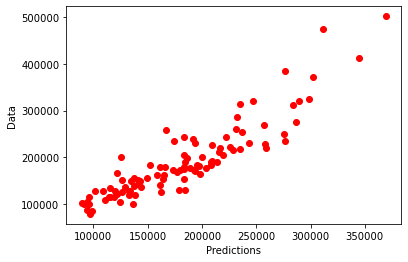

In [337]:
plt.scatter(predictions, Y, color='r')
plt.ylabel('Data')
plt.xlabel('Predictions')

Text(0.5, 0, 'Independant variables')

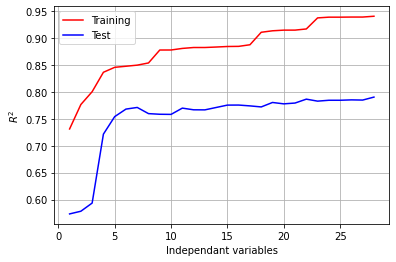

In [338]:
Rtraining=[]
Rtest=[]
for i in range(2,30,1):
    cols=corr['SalePrice'].sort_values(ascending=False)[0:i].index
    #pick out x cols and Y =SalePrice
    X=data[cols]
    Y=data['SalePrice']
    X=X.drop(['SalePrice'],axis=1).fillna(0)
    lr = linear_model.LinearRegression()
    model=lr.fit(X,Y)
    predictions=model.predict(X)
    Rtraining.append(model.score(X,Y))
    
    X=test[cols]
    Y=X['SalePrice']
    X=X.drop(['SalePrice'],axis=1).fillna(0)
    predictions=model.predict(X)
    Rtest.append(model.score(X,Y))
    
ListX=np.arange(1,len(Rtraining)+1,1)
    
plt.plot(ListX, Rtraining, label='Training', color='r')
plt.plot(ListX, Rtest, label='Test', color='b')
plt.grid(True)
plt.legend()
plt.ylabel(r'$R^2$')
plt.xlabel('Independant variables')

It can be seen that the model performs less than expected on the test data set. After 8 variables it starts to plateau. 

[Back to top](#Index)

## Conclusion

To conclude, the linear regression model performs well on this data set. Including more correlated independent variables improves the predictions. However, after 8 variables, the prediction starts to plateau. 

The next steps of this project are the following: compute the p-value of the linear regression, addimensionalize each variables before feeding them to the model and manipulate each variable in a way that they will all follow a normal distribution.
